# Creating Custom Captum.optim Modules
Captum's Optim library contains an extensive list of optimization objectives, transforms, and input parameterizations. However, some cases may require adding new features to these areas of Captum's Optim library. Luckily adding them to Captum is easy!

In [ ]:
%load_ext autoreload
%autoreload 2

from typing import Callable, Dict, List, Optional, Tuple, Union

import torch
import torchvision
from captum.optim.models import googlenet

import captum.optim as opt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device)

## Custom Image Transforms

If both Captum and Torchvision lack the transforms that you require, then you can create your own custom transforms.

Custom image transform classes must contain a `forward()` function. The first transform in a list of transforms takes an input tensor with a shape of (B, C, W, H), and the final transform in a list of transforms will need to output a tensor with the same shape of (B, C, W, H). Captum and Torchvision's transforms normally expect and output a shape of (B, C, W, H).

An optional `__init__()` function can be used as well.


Note that all custom transforms need to be autograd compatible, so that the gradient is not interrupted during the optimization process.


In [3]:
class CustomTransform(torch.nn.Module):
    def __init__(self, val: int = 1) -> None:
        super().__init__()
        self.val = val

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return input * self.val

## Custom Loss Functions
Captum's loss functions are composed of classes that the optimization function uses. Custom loss classes should inherit the base loss class `opt.loss.BaseLoss` and also have the `opt.loss.loss_wrapper` decorator.

For now, the `opt.loss.loss_wrapper` decorator primarily serves to update the name and string representations of the loss function, but future work may also add other generic loss attributes via the decorator.

Custom loss functions must contain the following two functions:


* The `__init__()` function must at least contain a `target` variable. The `target` variable should be an `nn.module` or list of `nn.modules` to collect activations from. Other variables can be added after the `target`. An optional variable is `batch_index`, which is an `int`. The `batch_index` is used to target a specific image in a batch of input images.

* The `__call__()` function takes activations from the target layer and then returns a loss value. Activations sent to the call function are extracted from a dictionary with the target as the key.

In [4]:
@opt.loss.loss_wrapper
class CustomLoss(opt.loss.BaseLoss):
    def __init__(self, target: Union[torch.nn.Module, List[torch.nn.Module]], batch_index: Optional[int] = None) -> "CustomLoss":
        opt.loss.BaseLoss.__init__(self, target, batch_index)

    def __call__(
        self, target_activations: Dict[torch.nn.Module, Optional[torch.Tensor]]
    ) -> torch.Tensor:
        # Get activations from target
        # self.batch_index is a tuple of (batch_index, batch_index+1)
        activations = target_activations[self.target][self.batch_index[0]:self.batch_index[1]]
        return activations

## Custom Loss Summarize Functions

In addition to the loss function, there is also the `loss_summarize_fn` that can be supplied to the `optimize` method of `InputOptimization`. This function dictates how the final loss is computed and aggregated before we call the `backward` method on it to compute gradients.

Here we show the default summarize function to give an idea of what this function does. The default summarize function simply computes the mean of the loss tensor and multiplies it by -1 so that the optimization maximizes the activations.

In [5]:
def custom_loss_summarize(loss_value: torch.Tensor) -> torch.Tensor:
    return -1 * loss_value.mean()

## Custom Image Parameterization


The image parameters that Captum's Optim library optimizes to produce visualizations are stored in a custom image parameterization class. 

Custom parameterization must contain the following two functions:

### Init function

The `__init__()` function has 4 input variables:

* size (tuple, int): dimensions in the form height, width. 

* channels (int): the number of channels for the output tensor.

* batch (int): the desired batch size to use.

* init (torch.Tensor): An optional input tensor with a shape of: (B, C, W, H).

Make sure that the tensor being optimized is wrapped in `torch.nn.Parameter` and that it can be called by the `forward()` function.

### Forward function

The `forward()` function has zero input varibles and returns a 4 dimension tensor with a shape of (B, C, W, H):

* The tensor being optimized should be called from where it was saved in the init function. This tensor will then be returned when the forward function is called.

* The dimensions of the output tensor should be named: 'B', 'C', 'H', and 'W'.

In [6]:
class CustomImage(opt.images.ImageParameterization):
    def __init__(
        self,
        size: Tuple[int, int] = (224, 224),
        channels: int = 3,
        batch: int = 1,
        init: torch.Tensor = None,
    ) -> None:
        super().__init__()
        if init is None:
            assert size is not None
            # Create random input with a shape of: B, C, W, H
            init = torch.randn([batch, channels, size[0], size[1]])
        else:
            assert init.dim() == 4
        self.image = torch.nn.Parameter(init)  # Convert input to nn.Parameter()

    def forward(self) -> torch.Tensor:
        return self.image.refine_names("B", "C", "H", "W")  # rename dimensions

## Custom NaturalImage

By default, `NaturalImage` handles the decorrelation and recorrelation of image parameterizations, and it ensures that the tensor object is an `ImageTensor`. If you need to create your own variation of `NaturalImage` to handle nonstandard optimization tasks, then doing so is rather simple.

### Init function

The `__init__()` function can be used to create the image parameterization instance, or it can take an image parameterization instance and stores it inside of the class. In the example below, we have all the input parameters specified by the init function of our image parameterization in our init function. We do this so that we can create our image parameterization inside of our custom `NaturalImage` class.

### Forward function

The `forward()` function takes the output from the image parameterization and returns it inside an instance of the `ImageTensor` class.

In [12]:
class CustomNaturalImage(opt.images.ImageParameterization):
    def __init__(
        self,
        size: Tuple[int, int] = [224, 224],
        channels: int = 3,
        batch: int = 1,
        init: Optional[torch.Tensor] = None,
        parameterization: opt.images.ImageParameterization = opt.images.PixelImage,
    ) -> None:
        super().__init__()
        if init is not None:
            assert init.dim() == 3 or init.dim() == 4

        # Save image parameterization so that we can call it in the forward function
        self.parameterization = parameterization(
            size=size, channels=channels, batch=batch, init=init
        )

    def forward(self) -> opt.images.ImageTensor:
        # Collect image from image parameterization
        image = self.parameterization()
        
        # Remove dimension names as many PyTorch operations don't yet support them
        image = image.rename(None)

        # Target input range is [0, 1] so we make sure all values fall within that range
        image = torch.sigmoid(image)

        # Return ImageTensor instance with our image tensor
        return opt.images.ImageTensor(image)

## Custom Optimization Function

While the default `optimize` sub function from `InputOptimization` usually suffices for most PyTorch optimizers, you may find yourself needing slightly different behaviour for a nonstandard optimizer. An example of this would be how optimizers like LBFGS require a `closure` [function passed to their step sub function](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step).

To create a custom optimization function, you can pass your `InputOptimization` instance that recreates the default `optimize` sub function.

In [13]:
def custom_optimize(
    obj: opt.InputOptimization,
    stop_criteria: Optional[Callable] = None,
    optimizer: Optional[torch.optim.Optimizer] = None,
    loss_summarize_fn: Optional[Callable] = None,
    lr: float = 0.025,
) -> torch.Tensor:

    # Setup conditions for when to stop optimizing
    stop_criteria = stop_criteria or opt.optimization.n_steps(512)

    # Pass the parameters of our optimization task to the optimizer
    optimizer = optimizer or torch.optim.Adam(obj.parameters(), lr=lr)
    assert isinstance(optimizer, torch.optim.Optimizer)

    # Set the loss summarization function
    loss_summarize_fn = loss_summarize_fn or opt.loss.default_loss_summarize

    history: List[torch.Tensor] = []
    step: int = 0

    # Run optimization loop with protection
    try:

        # Stop criteria requires 4 variables from the optimization process
        while stop_criteria(step, obj, history, optimizer):
            optimizer.zero_grad()

            # Summarize any non scalar loss values
            loss_value = loss_summarize_fn(obj.loss())

            # Place loss values from the current step into history list
            history.append(loss_value.clone().detach())

            loss_value.backward()
            optimizer.step()
            step += 1

    # Always run final clean up 
    finally:
        obj.cleanup()
    return torch.stack(history)

## Running Captum with custom modules

Below is a helper function that will let us quickly and easily experiment with our custom modules from above. Random scaling and random spatial jitter transforms are also included in the helper function to improve output quality.

In [14]:
def visualize(model: torch.nn.Module, target: torch.nn.Module):
    # Define our custom image parameterization, then add it to our custom NaturalImage
    image_param = CustomImage
    image = CustomNaturalImage(size=(224, 224), parameterization=image_param, batch=2).to(device)

    transforms = torch.nn.Sequential(
        CustomTransform(),  # Add our custom transform to the list of transforms

        # Additional transforms to improve output quality
        opt.transforms.RandomSpatialJitter(16),
        opt.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
    )

    # Define our custom loss function as the loss function
    loss_fn = CustomLoss(target, batch_index=0)  # Only optimize 0th image to demonstrate batch_index

    obj = opt.InputOptimization(model, loss_fn, image, transforms)
    history = custom_optimize(  # Our custom optimization function
        obj=obj,
        stop_criteria=opt.optimization.n_steps(512),
        loss_summarize_fn=custom_loss_summarize,  # Our custom loss_summarize_fn
    )
    image().show()

And there you have it! Notice that only the left image (at index 0) is optimized since we specified `batch_index=0` when defining `loss_fn`. The right image is unchanged from its random initialization.

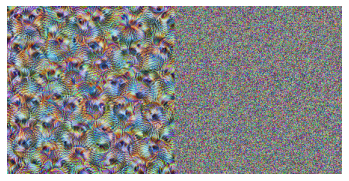

In [15]:
visualize(model, model.mixed4a)